In [47]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import cv2
from __future__ import print_function
import torch
import torch.nn.functional as F
from torchvision import transforms
import time
from google.colab.patches import cv2_imshow

In [49]:
# Load pretrained model
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
# Segment people only for the purpose of human silhouette extraction
people_class = 15

# Evaluate model
model.eval()
print ("Model has been loaded.")

blur = torch.FloatTensor([[[[1.0, 2.0, 1.0],[2.0, 4.0, 2.0],[1.0, 2.0, 1.0]]]]) / 16.0

# Use GPU if supported, for better performance
if torch.cuda.is_available():
	model.to('cuda')
	blur = blur.to('cuda')
	
# Apply preprocessing (normalization)
preprocess = transforms.Compose([
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to create segmentation mask
def makeSegMask(img):
    # Scale input frame
	frame_data = torch.FloatTensor( img ) / 255.0

	input_tensor = preprocess(frame_data.permute(2, 0, 1))
    
    # Create mini-batch to be used by the model
	input_batch = input_tensor.unsqueeze(0)

    # Use GPU if supported, for better performance
	if torch.cuda.is_available():
		input_batch = input_batch.to('cuda')

	with torch.no_grad():
		output = model(input_batch)['out'][0]

	segmentation = output.argmax(0)

	bgOut = output[0:1][:][:]
	a = (1.0 - F.relu(torch.tanh(bgOut * 0.30 - 1.0))).pow(0.5) * 2.0

	people = segmentation.eq( torch.ones_like(segmentation).long().fill_(people_class) ).float()

	people.unsqueeze_(0).unsqueeze_(0)
	
	for i in range(3):
		people = F.conv2d(people, blur, stride=1, padding=1)

	# Activation function to combine masks - F.hardtanh(a * b)
	combined_mask = F.relu(F.hardtanh(a * (people.squeeze().pow(1.5)) ))
	combined_mask = combined_mask.expand(1, 3, -1, -1)

	res = (combined_mask * 255.0).cpu().squeeze().byte().permute(1, 2, 0).numpy()

	return res


  

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Model has been loaded.


In [58]:
img = cv2.imread('/content/sddefault.png')

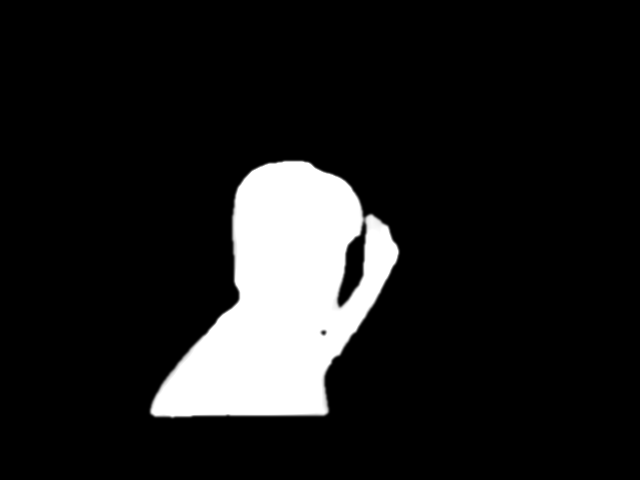

In [57]:
# Apply background subtraction to extract foreground (silhouette)
mask = makeSegMask(img)

# Apply thresholding to convert mask to binary map
ret,thresh = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

# Show extracted silhouette only, by multiplying mask and input frame
final = cv2.bitwise_and(thresh, img)

# Show current frame
cv2_imshow(mask)
